Import Packages

In [1]:
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
import glob
import json
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from utils import score, visualize_result, storeData, readData, create_sequences, setSeed
from pandas.plotting import register_matplotlib_converters
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import linregress
register_matplotlib_converters()


pollutant = ['O3', 'CO', 'NO2', 'SO2', 'PM2.5', 'PM10']
environment = ['RH', 'AMB_TEMP']


sgx_sensor_dict = {'c1_4#ec_na#0': 'O3',
                   'c1_0#ec_na#0': 'CO',
                   'c1_3#ec_na#0': 'NO2',
                   'c1_5#ec_na#0': 'SO2'}

unit_table = {'O3': 'ppb', 
              'CO': 'ppm',
              'NO2': 'ppb',
              'SO2': 'ppb'}


2023

In [3]:
ref_data = pd.read_csv('data/reference.csv', index_col = [0])
ref_data.index = pd.to_datetime(ref_data.index)
ref_data

,REF-O3,REF-CO,REF-NO2,REF-SO2,REF-PM2.5,REF-PM10,REF-RH,REF-AMB_TEMP
2023-01-01 00:00:00,38.7,0.23,4.8,1.0,14.0,14.0,86.0,18.4
2023-01-01 01:00:00,38.3,0.22,5.3,0.4,9.0,13.0,87.0,18.6
2023-01-01 02:00:00,38.3,0.22,4.4,0.2,6.0,8.0,89.0,18.5
2023-01-01 03:00:00,38.3,0.21,4.1,0.1,8.0,3.0,88.0,18.6
2023-01-01 04:00:00,38.2,0.20,3.9,0.5,5.0,4.0,88.0,18.9
...,...,...,...,...,...,...,...,...
2023-06-30 06:00:00,8.5,0.18,7.4,1.9,3.0,8.0,69.0,29.7
2023-06-30 07:00:00,8.8,0.28,8.4,1.5,3.0,10.0,67.0,30.8
2023-06-30 08:00:00,15.0,0.23,7.4,1.7,2.0,8.0,61.0,32.5
2023-06-30 09:00:00,22.2,0.20,6.9,1.8,7.0,14.0,60.0,33.2


SGX

In [4]:
sgx_data = pd.read_csv('data/sgx.csv', index_col = [0])
sgx_data.index = pd.to_datetime(sgx_data.index)
sgx_data

,SGX-O3,SGX-CO,SGX-NO2,SGX-SO2
measure_time,,,,
2023-01-01 08:00:00,-1.539167,6.763333,28.492500,115.645333
2023-01-01 09:00:00,-0.052000,5.354000,35.532833,143.715667
2023-01-01 10:00:00,-0.260333,5.516667,41.556333,168.006500
2023-01-01 11:00:00,-0.130000,5.578000,44.988500,184.928333
2023-01-01 12:00:00,-0.469000,6.089000,45.418000,196.317667
...,...,...,...,...
2023-06-29 03:00:00,0.000000,2.490667,34.718833,238.026000
2023-06-29 04:00:00,0.026000,2.659167,36.283000,196.418833
2023-06-29 05:00:00,0.000000,2.877000,34.536000,179.435000


SPEC

In [5]:
spec_data = pd.read_csv('data/spec.csv', index_col = [0])
spec_data.index = pd.to_datetime(spec_data.index)
spec_data

,SPEC-O3,SPEC-CO,SPEC-NO2,SPEC-SO2
measure_time,,,,
2023-01-07 11:00:00,-2.386834,5.747358,-14.257812,71.975528
2023-01-07 12:00:00,-2.239583,6.233724,-14.397786,80.398763
2023-01-07 13:00:00,-2.301432,6.930339,-15.050456,90.367839
2023-01-07 14:00:00,-2.664388,5.748698,-14.055990,75.003255
2023-01-07 15:00:00,-2.438151,5.312500,-12.535807,66.230469
...,...,...,...,...
2023-06-29 03:00:00,-1.953125,7.080078,-17.041016,52.001953
2023-06-29 04:00:00,-1.757812,7.480469,-18.027344,54.609375
2023-06-29 05:00:00,-1.841518,7.952009,-16.183035,54.268973


In [11]:
target_gas = 'O3'
data = pd.concat([ref_data, sgx_data, spec_data], axis = 1)
# data = data.abs()
data = data.reindex(data.index, fill_value=np.nan)
data = data[data.index.month <= 4]

In [12]:
data.dropna(subset=['REF-AMB_TEMP', 'REF-RH', f'SGX-{target_gas}', f'SPEC-{target_gas}', f'REF-{target_gas}'], inplace=True)
# Normalize the data
data = data.abs()
data = (data - data.min()) / (data.max() - data.min())

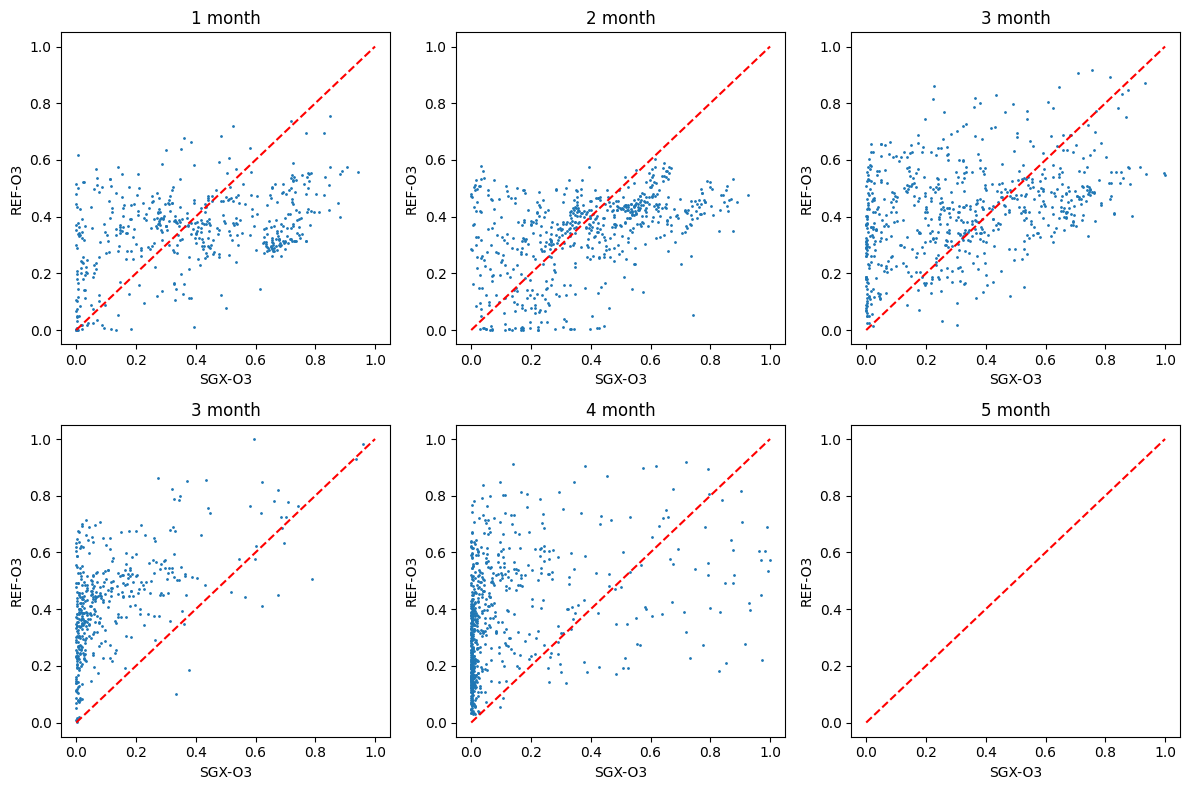

In [8]:
# plot the scatter plot of f'SPEC-{target_gas}'] and f'REF-{target_gas}']
# six months seperately
#draw a slope = 1 line
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
for i in range(2):
    for j in range(3):
        ax[i, j].scatter(data[f'SGX-{target_gas}'][data.index.month == i*3+j+1], data[f'REF-{target_gas}'][data.index.month == i*3+j+1], s=1)
        ax[i, j].plot([0, 1], [0, 1], 'r--')
        ax[i, j].set_xlabel(f'SGX-{target_gas}')
        ax[i, j].set_ylabel(f'REF-{target_gas}')
        ax[i, j].set_title(f'{i*2+j+1} month')
plt.tight_layout()
plt.show()


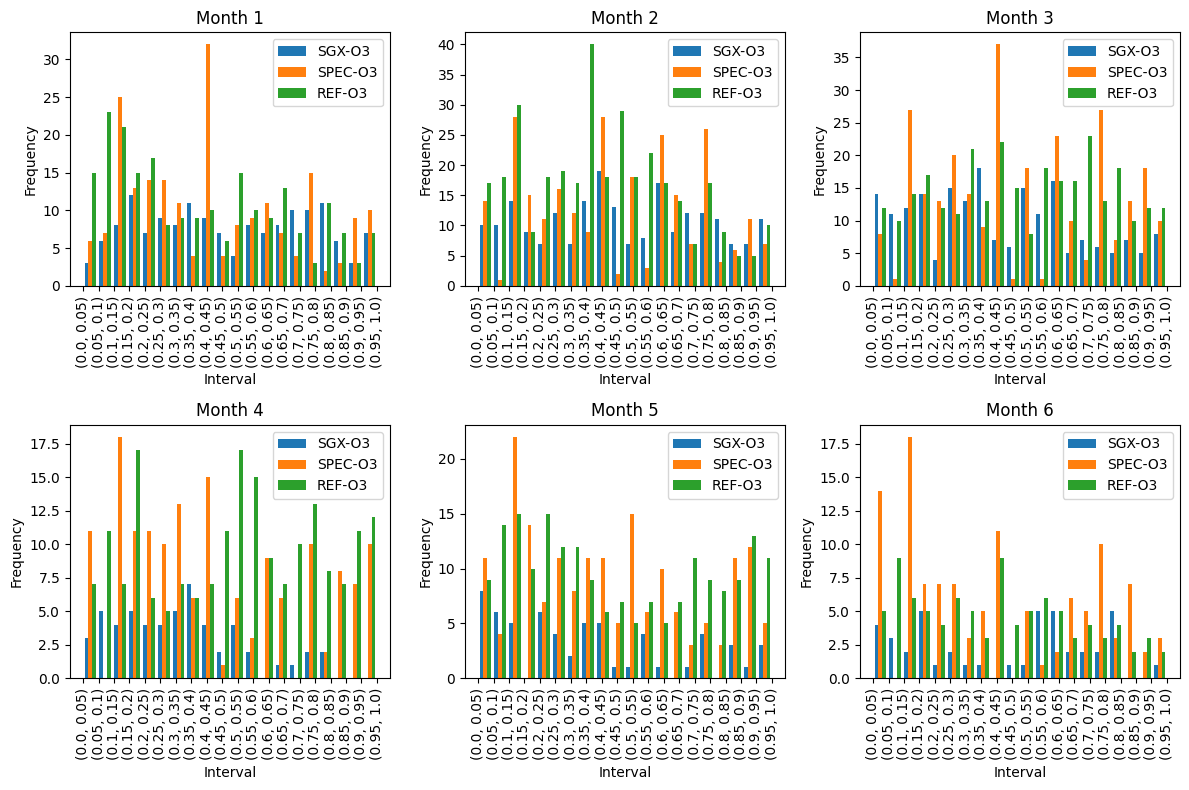

In [82]:
# Extract the required columns
sgx_CO = data[f'SGX-{target_gas}']
spec_CO = data[f'SPEC-{target_gas}']
ref_CO = data[f'REF-{target_gas}']

# Create a figure with a 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Iterate over the months and plot the histograms
for i, month in enumerate(range(1, 7)):
    # Filter the data for the current month
    monthly_data = data[data.index.month == month]
    
    # Select the respective O3 columns
    sgx_month = monthly_data[f'SGX-{target_gas}']
    spec_month = monthly_data[f'SPEC-{target_gas}']
    ref_month = monthly_data[f'REF-{target_gas}']
    
    # Calculate the bins and labels for the histograms
    bin_width = 0.05
    bins = [i / 100 for i in range(0, 101, int(bin_width * 100))]
    bin_labels = [(bins[i], bins[i+1]) for i in range(len(bins)-1)]
    
    # Calculate the binned values for each O3 column
    sgx_binned_values = pd.cut(sgx_month, bins=bins, labels=False)
    spec_binned_values = pd.cut(spec_month, bins=bins, labels=False)
    ref_binned_values = pd.cut(ref_month, bins=bins, labels=False)
    
    # Determine the subplot position in the grid
    row = i // 3
    col = i % 3
    
    # Plot the histograms in the respective subplot
    axes[row, col].hist([sgx_binned_values, spec_binned_values, ref_binned_values], bins=len(bin_labels),
                        label=[f"SGX-{target_gas}", f"SPEC-{target_gas}", f"REF-{target_gas}"])
    axes[row, col].set_xticks(range(len(bin_labels)))
    axes[row, col].set_xticklabels(bin_labels, rotation=90)
    axes[row, col].set_xlabel("Interval")
    axes[row, col].set_ylabel("Frequency")
    axes[row, col].set_title(f"Month {month}")
    axes[row, col].legend()

# Adjust the layout and spacing
plt.tight_layout()

# Show the figure
plt.show()

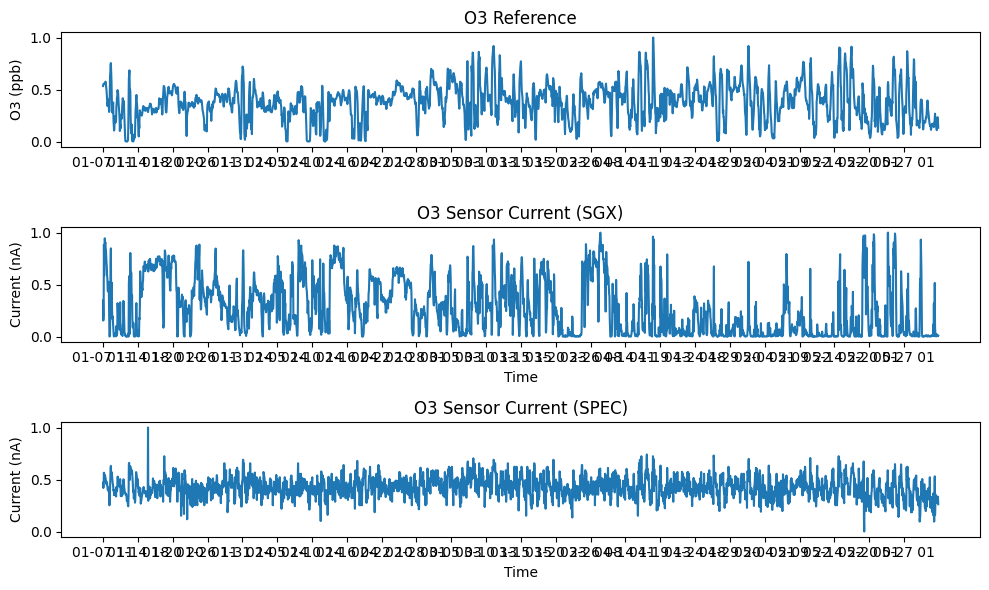

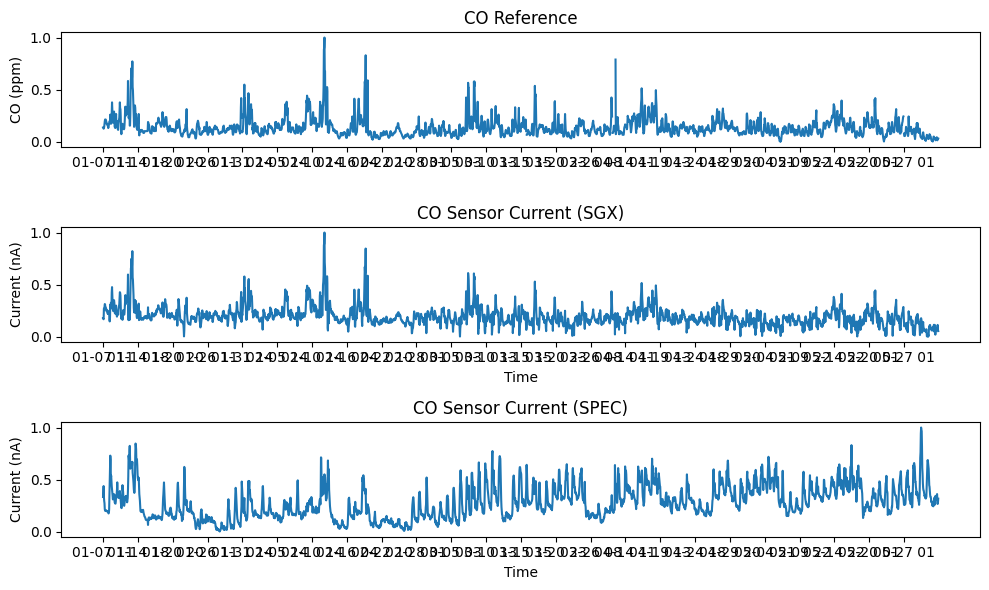

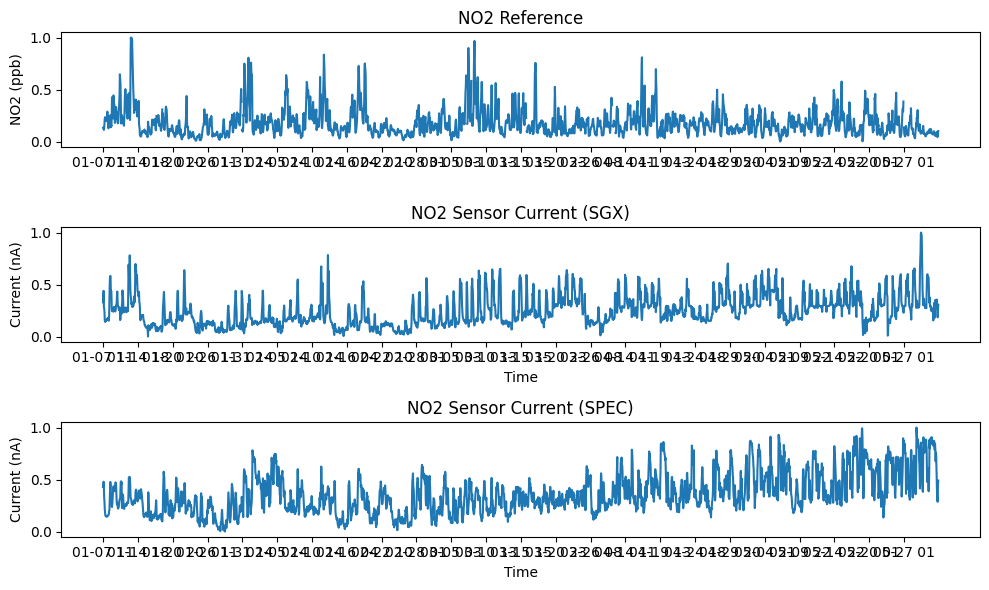

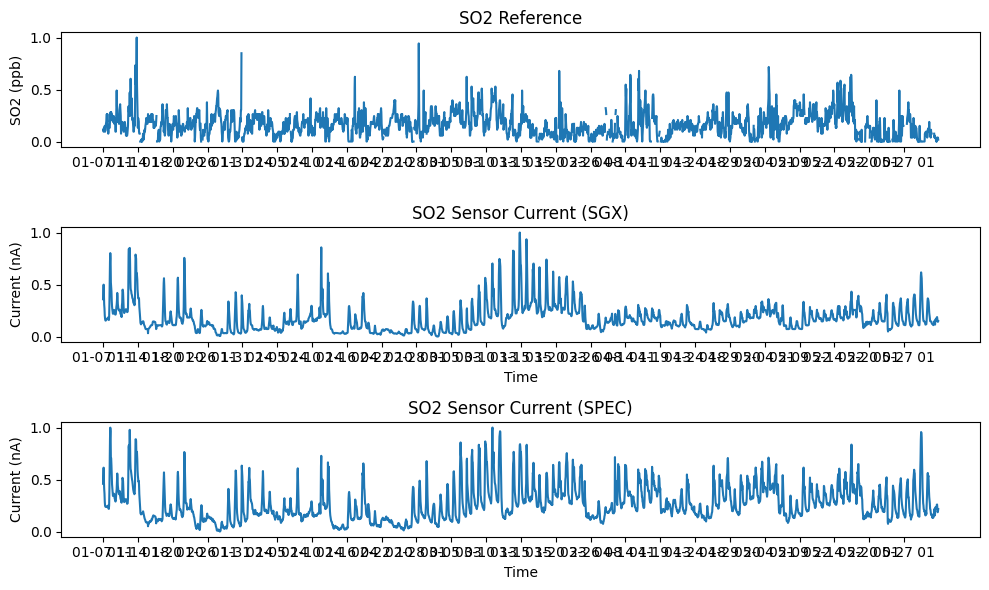

In [9]:
for gas in pollutant[:4]:
    labels = list(map(lambda x: str(x)[5:13], data.index[::120]))
    fig = plt.figure(figsize=(10, 6))

    ax1 = plt.subplot(311)
    ax1.set_title(f'{gas} Reference')
    ax1.plot(data['REF-' + gas].values, label = 'Reference Station')
    ax1.set_xticks(ticks = list(np.arange(0, len(data.index), 120)))
    ax1.set_xticklabels(labels = labels, rotation = 0)
    ax1.set_ylabel(f'{gas} ({unit_table[gas]})')
    

    ax2 = plt.subplot(312, sharex = ax1)
    ax2.set_title(f'{gas} Sensor Current (SGX)')
    ax2.plot(data['SGX-' + gas].values, label = 'SGX')
    ax2.set_xticks(ticks = list(np.arange(0, len(data.index), 120)))
    ax2.set_xticklabels(labels = labels, rotation = 0)
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Current (nA)')

    ax3 = plt.subplot(313, sharex = ax1)
    ax3.set_title(f'{gas} Sensor Current (SPEC)')
    ax3.plot(data['SPEC-' + gas].values, label = 'SPEC')
    ax3.set_xticks(ticks = list(np.arange(0, len(data.index), 120)))
    ax3.set_xticklabels(labels = labels, rotation = 0)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Current (nA)')

    plt.tight_layout()
    plt.savefig(f'fig/{gas}_comparison.png', dpi=300, bbox_inches='tight')


Correlation heatmap

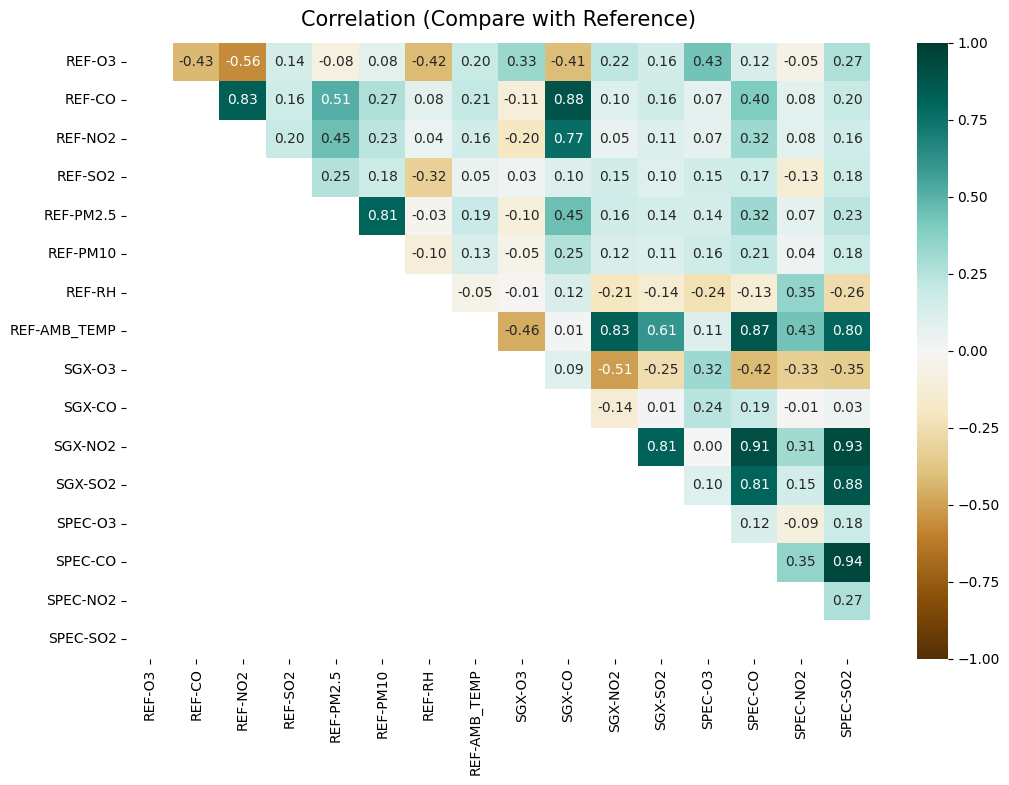

In [13]:
df = data.dropna().iloc[:, :]
plt.figure(figsize=(12, 8))
# define the mask to set the values in the upper triangle to True
mask = np.tril(np.ones_like(df.corr(), dtype=bool))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG', mask=mask, fmt=".2f")
heatmap.set_title('Correlation (Compare with Reference)', fontdict={'fontsize':15}, pad=12)
plt.savefig('./fig/correlation_heatmap_outer.png', dpi=300, bbox_inches='tight')

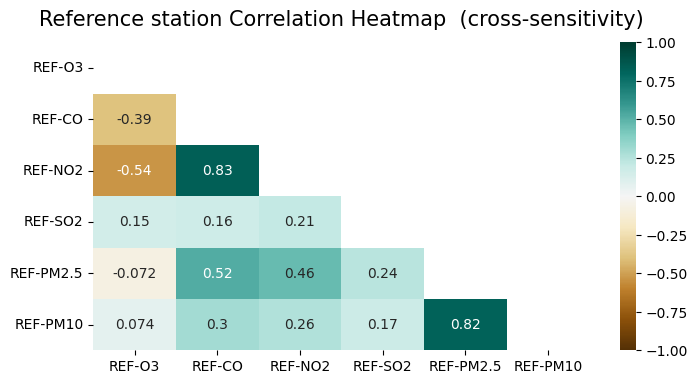

In [18]:
df = data.dropna().iloc[:, 0:6]
plt.figure(figsize=(8, 4))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Reference station Correlation Heatmap  (cross-sensitivity)', fontdict={'fontsize':15}, pad=12)
plt.savefig('./fig/ref_correlation_heatmap.png', dpi=300, bbox_inches='tight')

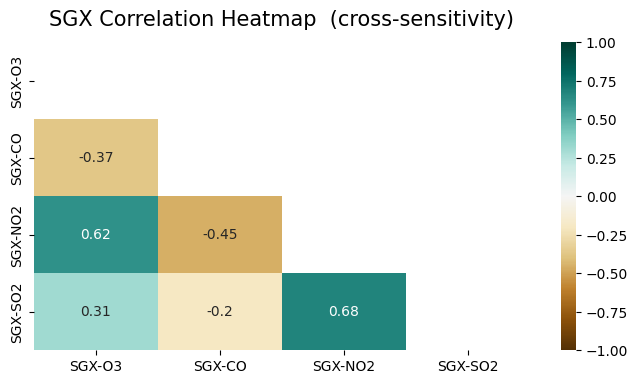

In [62]:
df = data.dropna().iloc[:, 8:12]
plt.figure(figsize=(8, 4))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('SGX Correlation Heatmap  (cross-sensitivity)', fontdict={'fontsize':15}, pad=12)
plt.savefig('./fig/sgx_correlation_heatmap.png', dpi=300, bbox_inches='tight')

Target Gas & Settings

In [10]:
gas = 'CO'

In [23]:
df = data.dropna()
df['week'] = df.index.isocalendar().week

# Calculate the mean and standard deviation
mean_sgx, std_sgx = df[f'SGX-{gas}'].mean(), df[f'SGX-{gas}'].std()
mean_ref, std_ref = df[f'REF-{gas}'].mean(), df[f'REF-{gas}'].std()

# Define a condition for values within 2 standard deviations
condition_sgx = np.abs(df[f'SGX-{gas}'] - mean_sgx) <= 2*std_sgx
condition_ref = np.abs(df[f'REF-{gas}'] - mean_ref) <= 2*std_ref

# Apply the condition to the dataframe
df = df[condition_sgx & condition_ref]


C:\Users\user\AppData\Local\Temp\ipykernel_5608\1513354595.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['week'] = df.index.isocalendar().week


Sensor Drift #1

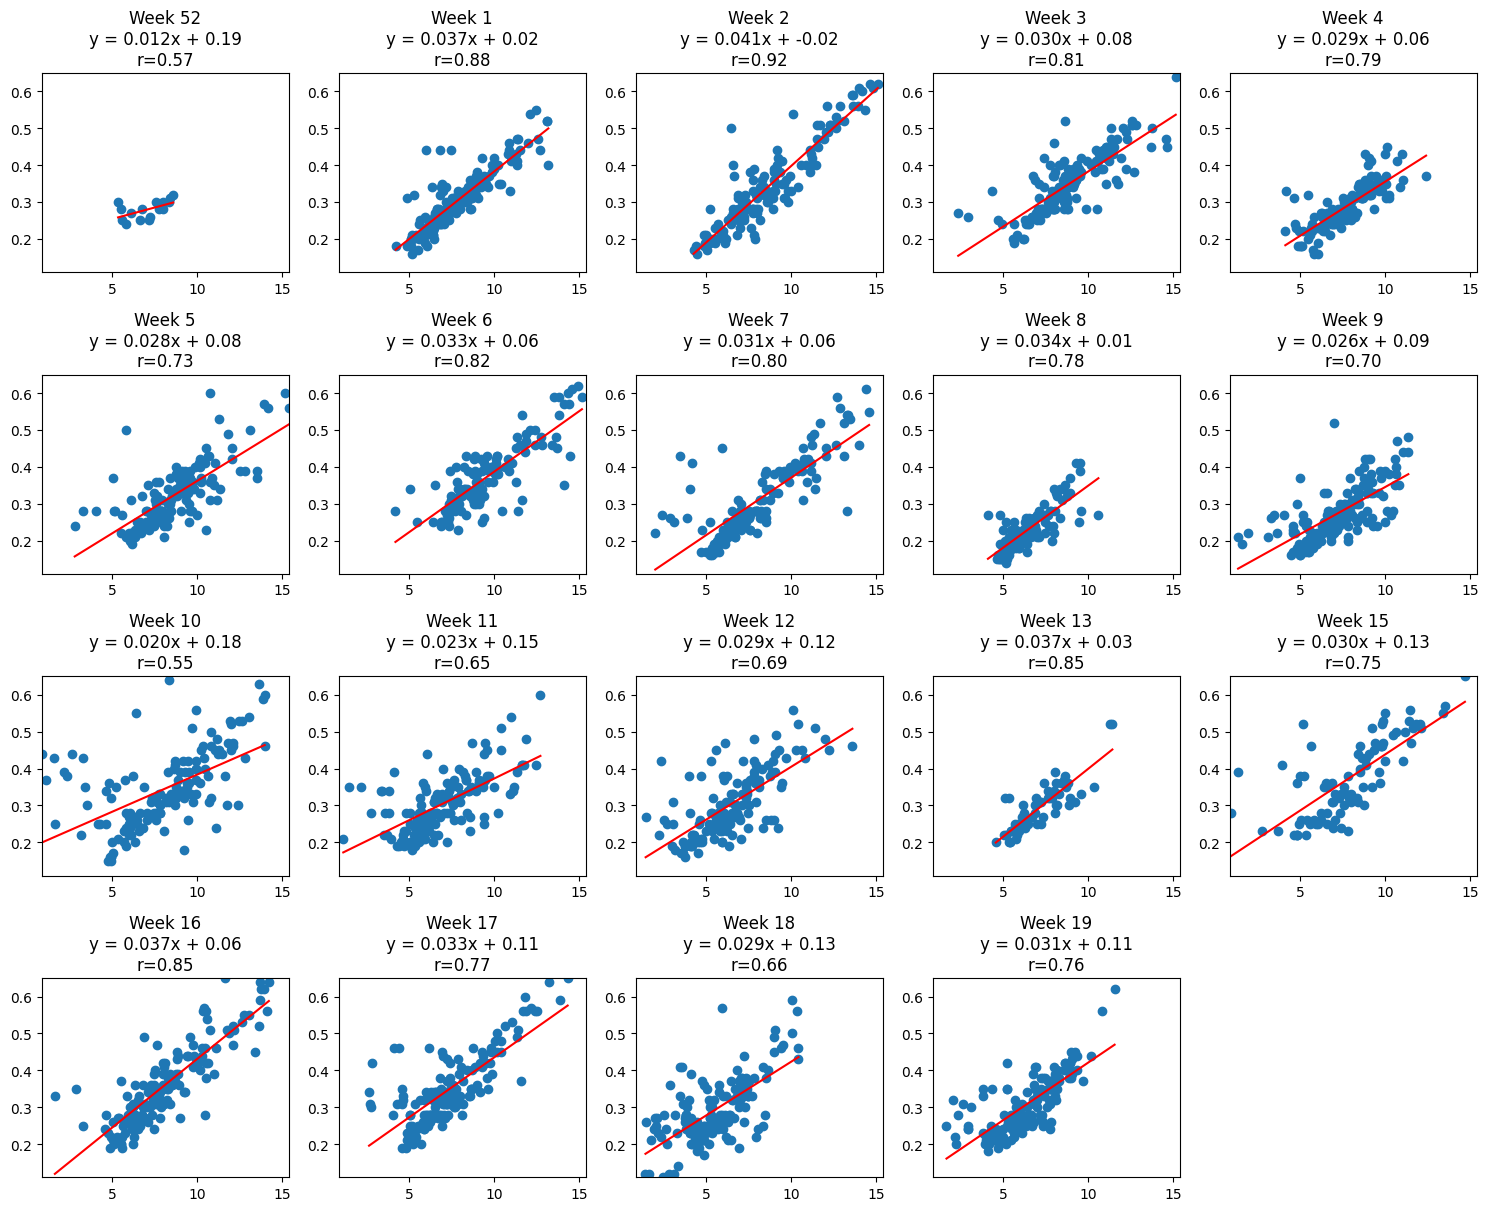

In [24]:
# Determine the grid size for subplots
grid_size = int(np.ceil(np.sqrt(df['week'].nunique())))

# Calculate the global minimum and maximum for sensor data and station data
global_x_min, global_x_max = df[f'SGX-{gas}'].min(), df[f'SGX-{gas}'].max()
global_y_min, global_y_max = df[f'REF-{gas}'].min(), df[f'REF-{gas}'].max()

fig, axs = plt.subplots(grid_size, grid_size, figsize=(15, 15))

# Flatten the axis array to make indexing easier
axs = axs.flatten()

# Record the slope, r
slopes = []
rs = []

# For each week
for i, week in enumerate(df['week'].unique()):
    # Select the data for this week
    subset = df[df['week'] == week]
    
    # Create the scatter plot
    axs[i].scatter(subset[f'SGX-{gas}'], subset[f'REF-{gas}'])
    
    # Calculate the regression line parameters
    slope, intercept, r_value, p_value, std_err = linregress(subset[f'SGX-{gas}'], subset[f'REF-{gas}'])
    slopes.append(slope)
    rs.append(r_value)

    # Add the regression line
    x = np.linspace(subset[f'SGX-{gas}'].min(), subset[f'SGX-{gas}'].max())
    y = slope * x + intercept
    axs[i].plot(x, y, color='red')
    
    # Create the equation string
    equation = f'y = {slope:.3f}x + {intercept:.2f}'
    stats_text = f'r={r_value:.2f}'
    
    # Set the title to include the equation
    axs[i].set_title(f'Week {week}\n{equation}\n{stats_text}')

    # Set the x and y limits to the global minimum and maximum
    axs[i].set_xlim(global_x_min, global_x_max)
    axs[i].set_ylim(global_y_min, global_y_max)

# Remove extra subplots
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


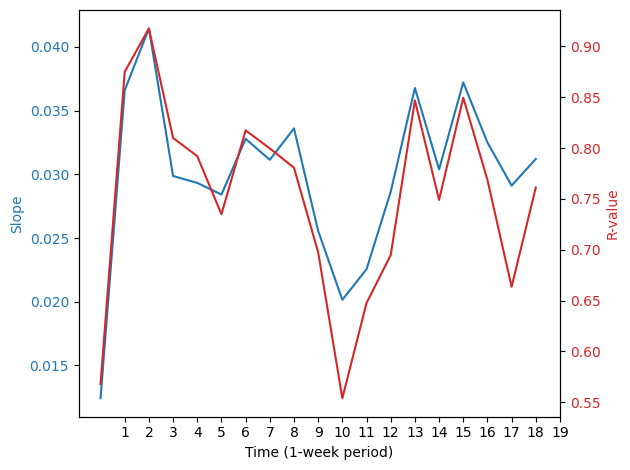

In [27]:
fig, ax1 = plt.subplots()

# Plot the slopes on the left y-axis
color = 'tab:blue'
ax1.set_xlabel('Time (1-week period)')
ax1.set_ylabel('Slope', color=color)
ax1.plot(slopes, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Set x-ticks to be the weeks of the year
xticks = list(range(1, len(slopes) + 1))
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks)

# Create a second y-axis with the same x-axis
ax2 = ax1.twinx()

# Plot the r-values on the right y-axis
color = 'tab:red'
ax2.set_ylabel('R-value', color=color)
ax2.plot(rs, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Set x-ticks to be the weeks of the year for the second y-axis
ax2.set_xticks(xticks)
ax2.set_xticklabels(xticks)

fig.tight_layout()
plt.show()


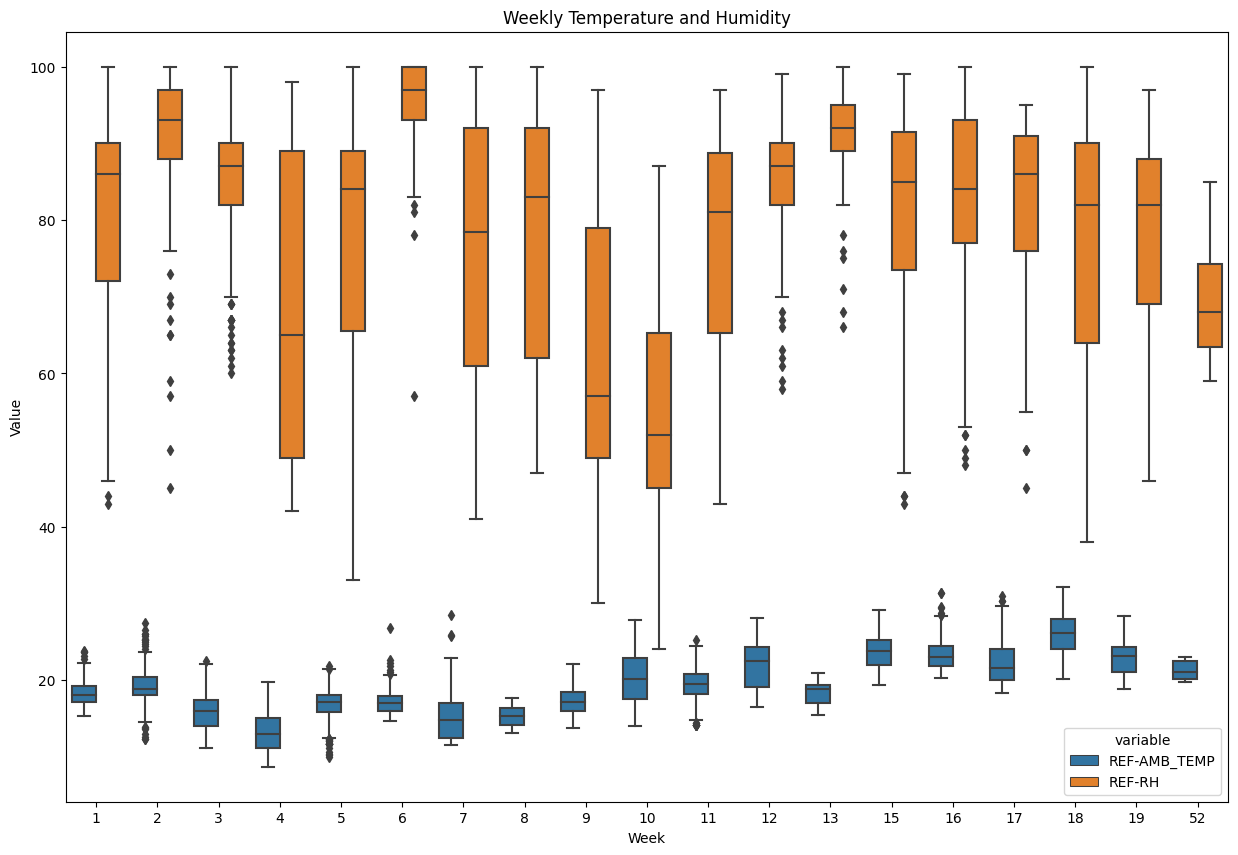

In [28]:


# Prepare the data
df_melted = df.melt(id_vars='week', value_vars=['REF-AMB_TEMP', 'REF-RH'])

# Create the boxplot
plt.figure(figsize=(15, 10))
sns.boxplot(x='week', y='value', hue='variable', data=df_melted)
plt.title('Weekly Temperature and Humidity')
plt.xlabel('Week')
plt.ylabel('Value')
plt.show()
